## Pyro, Bayesian analysis, and attempt on BCRF (Qi et al 2005)

In [1]:
import pyro
from pyro.distributions import Normal, Uniform
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, EmpiricalMarginal, TraceEnum_ELBO, JitTraceEnum_ELBO
from pyro.infer.mcmc import MCMC, NUTS
from pyro.optim import Adam
from pyro.util import ignore_jit_warnings
from pyro.contrib.autoguide import AutoDelta

import torch
import torch.nn as nn

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

In [2]:
DATA_URL = "https://d2fefpcigoriu7.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])

In [3]:
data = torch.tensor(df.values, dtype=torch.float)
x_data, y_data = data[:, :-1], data[:, -1]

In [4]:
def model(x_data, y_data):
    n = len(x_data)

    # w, b, sigma parameter is outside of plate, independent of N
    weight = pyro.sample("w", dist.Normal(torch.zeros(1, 2), torch.ones(1, 2)))
    bias = pyro.sample("b", dist.Normal(torch.tensor([[0.]]), torch.tensor([[100.]])))
    sigma = pyro.sample("epsilon", Uniform(0., 10.))

    with pyro.plate("map", n):
        mu = (x_data[:, 0] * weight[0][0] + x_data[:, 1] * weight[0][1] + bias).squeeze(1)
        yhat = pyro.sample("yhat", Normal(mu, sigma), obs=y_data)
        return yhat

## Stochastic Variational Inference with spherical gaussian on linear regression

In [5]:
from pyro.contrib.autoguide import AutoDiagonalNormal
mean_field_guide = AutoDiagonalNormal(model)

# inject callables into SVI instantiation
svi = SVI(model, mean_field_guide, Adam({"lr": 0.03}), loss=Trace_ELBO(), num_samples=1000)

In [6]:
pyro.clear_param_store()
for j in range(2000):
    loss = svi.step(x_data, y_data)
    if j % 500 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(data)))

[iteration 0001] loss: 3.8931
[iteration 0501] loss: 3.3034
[iteration 1001] loss: 1.5386
[iteration 1501] loss: 1.4807


In [7]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

auto_loc tensor([-1.3913, -0.0331,  9.0494, -2.2267], requires_grad=True)
auto_scale tensor([0.1296, 0.0425, 0.0774, 0.0754], grad_fn=<AddBackward0>)


## No-U-turn Sampler

In [8]:
pyro.clear_param_store()

nuts = NUTS(model)
sampler = MCMC(nuts,
               num_samples=600,
               num_chains=1,
               # burn-in
               warmup_steps=100)
traces = sampler.run(x_data, y_data)

Sample: 100%|██████████| 700/700 [00:12<00:00, 56.57it/s, step size=2.64e-01, acc. prob=0.927]


In [9]:
posteriors = traces.marginal(["w", "b", "epsilon"])

In [10]:
a = posteriors.empirical["epsilon"]

In [11]:
def get_marginal(traces, sites):
    return EmpiricalMarginal(traces, sites)._get_samples_and_weights()[0].detach().cpu().numpy()

In [12]:
posterior_weight = posteriors.empirical["w"]
posterior_bias = posteriors.empirical["b"]
posterior_epsilon = posteriors.empirical["epsilon"]

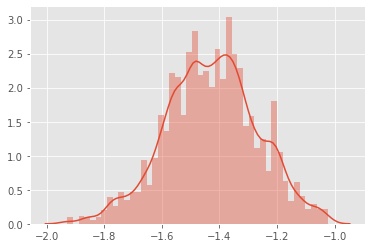

In [13]:
sns.distplot(posterior_weight((10000, )).squeeze(1)[:, 0])

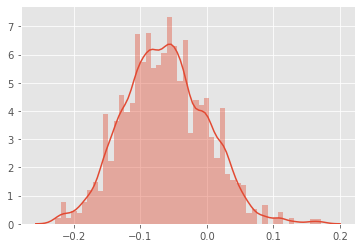

In [14]:
sns.distplot(posterior_weight((10000, )).squeeze(1)[:, 1])

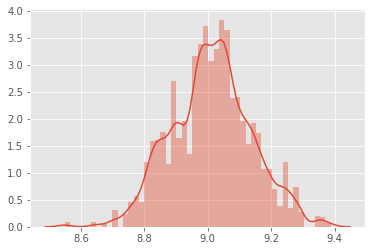

In [15]:
sns.distplot(posterior_bias((10000, )))

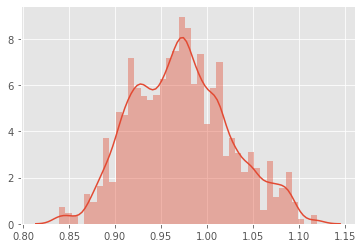

In [16]:
sns.distplot(posterior_epsilon((10000, )))

## vanila HMM before going BCRF (Qi et al. 2005)

In [34]:
# adopted from HMM tutorials at: https://pyro.ai/examples/hmm.html

In [45]:
# Pyro's poutine handles effects 
from pyro import poutine
import dmm.polyphonic_data_loader as poly

In [135]:
class MockArgs():
    num_steps=50
    hidden_dim=16
    nn_dim=48
    batch_size=8
    nn_channels=2
    learning_rate=0.05
    truncate=None
    print_shapes=False
    jit=True
    cuda=True
    raftery_parameterization=True

In [136]:
args = MockArgs()

In [137]:
if args.cuda:
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [138]:
# JSB Chorales dataset, pianos keys pressed out of 88 keys.
# Modeling Temporal Dependencies in High-Dimensional Sequences: Application to Polyphonic Music Generation and Transcription
# http://www-etud.iro.umontreal.ca/~boulanni/icml2012
data = poly.load_data(poly.JSB_CHORALES)

In [139]:
sequences = data['train']['sequences']
lengths = data['train']['sequence_lengths']

In [140]:
# only some keys of this piano were pressed, some not, so reduce dimension of the sequence
notes_pressed = ((sequences == 1).sum(0).sum(0) > 0)

In [141]:
sequences = sequences[:, :, notes_pressed]

In [142]:
if args.truncate:
    lengths.clamp_(max=args.truncate)
    sequences = sequences[:, :args.truncate]
num_observations = float(lengths.sum())

In [211]:
def model_1(sequences, lengths, args, batch_size=None, include_prior=True):
    # Sometimes it is safe to ignore jit warnings. Here we use the
    # pyro.util.ignore_jit_warnings context manager to silence warnings about
    # conversion to integer, since we know all three numbers will be the same
    # across all invocations to the model.
    with ignore_jit_warnings():
        num_sequences, max_length, data_dim = map(int, sequences.shape)
        assert lengths.shape == (num_sequences, )
        assert lengths.max() <= max_length

    with poutine.mask(mask=include_prior):
        # to_event seperates n right-most dimension as event dimension from batch dimension.
        # transition probability p(y_t | y_t-1)
        probs_x = pyro.sample("probs_x", dist.Dirichlet(0.9 * torch.eye(args.hidden_dim) + 0.1).to_event(1))
        # emission probability p(x_t | y_t)
        probs_y = pyro.sample("probs_y", dist.Beta(0.1, 0.9).expand([args.hidden_dim, data_dim]).to_event(2))

    # nodes_plate in shape [DATA_DIM], in this case 51 dimension of each observation
    nodes_plate = pyro.plate("nodes", data_dim, dim=-1)
    # We subsample batch_size items out of num_sequences items. Note that since
    # we're using dim=-1 for the notes plate, we need to batch over a different
    # dimension, here dim=-2.
    with pyro.plate("sequences", size=num_sequences, subsample_size=batch_size, dim=-2) as batch:
        # here batch is indice of subsampled, in shape [BATCH_SIZE, 1].
        lengths = lengths[batch]
        x = 0

        # If we are not using the jit, then we can vary the program structure
        # each call by running for a dynamically determined number of time
        # steps, lengths.max(). However if we are using the jit, then we try to
        # keep a single program structure for all minibatches; the fixed
        # structure ends up being faster since each program structure would
        # need to trigger a new jit compile stage.
        for t in pyro.markov(range(max_length if args.jit else lengths.max())):
            with poutine.mask(mask=(t < lengths).unsqueeze(-1)):
                x = pyro.sample("x_{}".format(t), dist.Categorical(probs_x[x]), infer={"enumerate": "parallel"})
                # x sampled in batch from categorical distribution of [0, 1, 2, ..., hidden_dim]
                # x is the state of the latent variable x at discrete time step t
                with nodes_plate:
                    # y in size [BATCH_SIZE, DATA_DIM]
                    y = pyro.sample("y_{}".format(t), dist.Bernoulli(probs_y[x.squeeze(-1)]),
                                    # observed these y at t
                                    obs=sequences[batch, t])

In [144]:
pyro.clear_param_store()
model = model_1

In [145]:
from pyro.contrib.autoguide import AutoDelta, AutoDiagonalNormal
# Delta distribution for constrained MAP inference
guide = AutoDelta(poutine.block(model, expose_fn=lambda msg: msg["name"].startswith("probs_")))

In [146]:
elbo = JitTraceEnum_ELBO(max_plate_nesting=2, strict_enumeration_warning=True)
optim = Adam({'lr': 1e-2})
svi = SVI(model, guide, optim, elbo)

In [147]:
for step in range(args.num_steps * 10):
    loss = svi.step(sequences, lengths, args=args, batch_size=args.batch_size)
    if not step % 100:
        print('{: >5d}\t{}'.format(step, loss / num_observations))

    0	19.18508048453683
  100	20.880658361700586
  200	14.033231558267545
  300	12.38031206996451
  400	10.788302582023611


In [148]:
num_sequences, max_length, data_dim = map(int, sequences.shape)

In [217]:
p = pyro.sample("probs_y", dist.Beta(0.1, 0.9).expand([args.hidden_dim, 51]).to_event(2))

In [219]:
p

tensor([[2.8638e-01, 5.9461e-03, 4.2826e-12, 2.3140e-02, 8.6210e-04, 5.9648e-02,
         2.7255e-04, 3.7092e-05, 2.4067e-01, 1.7834e-02, 5.8628e-04, 1.2980e-01,
         1.2667e-04, 2.8480e-12, 9.2430e-01, 1.0605e-06, 2.0156e-03, 2.2000e-03,
         1.5242e-05, 4.5344e-01, 3.1015e-01, 8.5108e-03, 1.0955e-05, 3.8672e-09,
         7.2950e-08, 1.1550e-02, 1.7969e-03, 6.0300e-11, 4.6658e-05, 1.2123e-06,
         9.3258e-04, 4.7549e-13, 1.2852e-04, 3.2006e-03, 6.1718e-14, 6.1069e-01,
         7.1953e-02, 9.6520e-01, 1.6206e-08, 1.4169e-09, 3.1905e-03, 1.9160e-03,
         8.6589e-04, 5.8077e-08, 6.1447e-01, 1.1874e-02, 3.6840e-08, 4.5848e-04,
         1.7224e-09, 1.0148e-06, 9.9868e-01],
        [7.9323e-01, 2.2905e-05, 3.5577e-01, 1.1069e-01, 3.0502e-01, 5.3663e-04,
         2.1107e-01, 7.2171e-03, 2.0026e-03, 9.1042e-08, 1.0407e-02, 3.2064e-05,
         3.4369e-05, 3.3400e-03, 3.1064e-02, 2.0864e-02, 5.2313e-01, 3.0999e-01,
         1.7683e-11, 7.5345e-02, 1.3495e-07, 2.8434e-08, 3.1471